### Investigating pinchouts

In [1]:
import numpy as np
import pandas as pd
import numbers

In [2]:
bore_info = pd.read_excel("../Geological_data/Dwer_data\Formation picks.xls",sheet_name = "bore_info2")
strat_info = pd.read_excel("../Geological_data/Dwer_data\Formation picks.xls",sheet_name = "strat_info2")

In [3]:
df = bore_info.copy()
x0, x1, y0, y1, z0, z1 = 0, 4000, 0, 1000, -400, 200
df = df.drop(['Source'], axis=1)
df = df.drop(['Tr','Tkm', 'Tk','Tkc','Jc','Kcom','Kps','Kpo','Kpc','Kcoh','Kcp','Kcl','Kcg', 'Kcm', 'Kcok','Kwg','Kws','Jy','Kwlw','Kwlm'], axis=1)
df = df.reset_index(drop=True)

lithcodes = list(df.columns.values[3:])   # Make a list of formations  
df.Easting = pd.to_numeric(df.Easting)    # Make sure Eastings and Northings are numeric values
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)
print(lithcodes)
df

['Ground', 'TQ', 'Kwlp']


,Easting,Northing,ID,Ground,TQ,Kwlp
0,1000,500,A,0,-100,-
1,2000,500,B,0,-100,-200
2,3000,500,C,0,-100,-


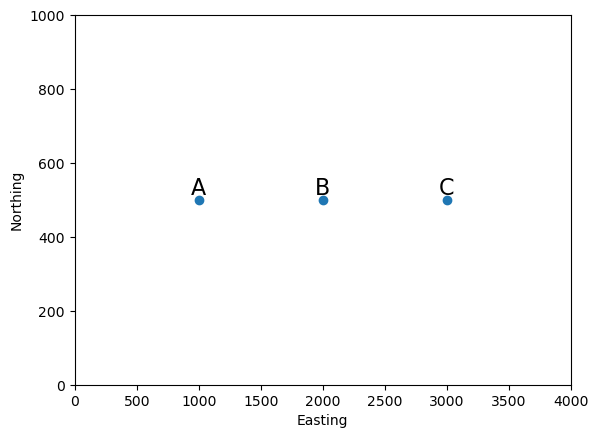

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

figure = True
if figure:
    plt.scatter(df.Easting, df.Northing)
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    i = 0
    for (xi, yi) in zip(df.Easting, df.Northing):
        plt.text(xi, yi, df.ID[i], size = 16, va='bottom', ha='center')
        i += 1
        plt.xlim(x0,x1)
        plt.ylim(y0,y1)

In [5]:
strat = []
for i, lith in enumerate(lithcodes):
    index = i
    lithid = i-1
    val = 100 - i*10 # arbitrary isolvalue
    sequence = strat_info.loc[strat_info['unit'] == lith, 'sequence'].item() 
    R = strat_info.loc[strat_info['unit'] == lith, 'R'].item()/255
    G = strat_info.loc[strat_info['unit'] == lith, 'G'].item()/255
    B = strat_info.loc[strat_info['unit'] == lith, 'B'].item()/255
    strat.append([index, lithid, lith, sequence, val, [round(R,2),round(G,2),round(B,2)]])
strat = pd.DataFrame(strat)
strat.columns =['index','lithid','lithcode','sequences','vals','color']
print('STRATIGRAPHY\n\n')
strat

STRATIGRAPHY




,index,lithid,lithcode,sequences,vals,color
0,0,-1,Ground,Ground,100,"[1.0, 1.0, 1.0]"
1,1,0,TQ,Quaternary,90,"[1.0, 1.0, 0.0]"
2,2,1,Kwlp,Warnbro,80,"[0.8, 1.0, 0.2]"


### Make lithology table for Loop

In [45]:
data_list = df.values.tolist()             # Turn data into a list of lists
formatted_data = []

for i in range(len(data_list)): #iterate for each row
    
    boreid = data_list[i][2]
    easting, northing = data_list[i][0], data_list[i][1]
    groundlevel = data_list[i][3]    
           
    # Add data for groundlevel
    val = strat.vals[0]
    #if boreid == 'B':
    gx, gy, gz = 0,0,1
    #else:
    #gx, gy, gz = np.nan, np.nan, np.nan
        
    formatted_data.append([boreid, easting, northing, groundlevel, val, 'Ground', 'Ground', gx, gy, gz]) 

    # Add data row for each lithology
    count = 1
    for j in range(4,df.shape[1]): #iterate through each formation 
        
        # Add lithology
        if isinstance(data_list[i][j], numbers.Number) == True:    
            bottom    = groundlevel + float(data_list[i][j])  # Ground surface - formation bottom (mbgl)
            val       = strat.vals[count]                      # designated isovalue
            lithid    = lithcodes[count]                       # lithology id 
            feat_name = strat.sequences[count]                 # sequence name
            #if lithid == 'Kwlp' or lithid == 'Kwlm':
            #else: 
            gx, gy, gz = 0,0,1
            formatted_data.append([boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz])    
   
    # For absent units, put in a dummy point in    
        else:
            lithid    = lithcodes[count]                       # lithology id 
            print(lithid, ' is absent in ',boreid)
            if lithid == 'Kwlp':
                
                bottom    = current_bottom  + 50
            if lithid == 'Kwlm':
                bottom    = current_bottom 
            val       = strat.vals[count]                      # designated isovalue
            
            feat_name = strat.sequences[count]                 # sequence name
            gx, gy, gz = 0,0,1
            formatted_data.append([boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz])

        current_bottom = np.copy(bottom)
        count+=1
        
data = pd.DataFrame(formatted_data)
data.columns =['ID','X','Y','Z','val','lithcode','feature_name', 'gx', 'gy', 'gz']

sequences = data['feature_name'].unique()
data

Kwlp  is absent in  A
Kwlp  is absent in  C


,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz
0,A,1000,500,0.0,100,Ground,Ground,0,0,1
1,A,1000,500,-100.0,90,TQ,Quaternary,0,0,1
2,A,1000,500,-50.0,80,Kwlp,Warnbro,0,0,1
3,B,2000,500,0.0,100,Ground,Ground,0,0,1
4,B,2000,500,-100.0,90,TQ,Quaternary,0,0,1
5,B,2000,500,-200.0,80,Kwlp,Warnbro,0,0,1
6,C,3000,500,0.0,100,Ground,Ground,0,0,1
7,C,3000,500,-100.0,90,TQ,Quaternary,0,0,1
8,C,3000,500,-50.0,80,Kwlp,Warnbro,0,0,1


In [46]:
for lith in lithcodes:
    filtered_df = data[data.lithcode == lith] 
    #print('\n')
    #print(filtered_df)
    #print(filtered_df.to_string(index=False))

### Create Geomodel

In [47]:
from LoopStructural import GeologicalModel
origin  = (x0, y0, z0)
maximum = (x1, y1, z1)
geomodel = GeologicalModel(origin, maximum)
geomodel.data = data

### Add surfaces

In [48]:
Ground     = geomodel.create_and_add_foliation("Ground")
GroundUC   = geomodel.add_unconformity(Ground, 100) # Clips above

Quaternary = geomodel.create_and_add_foliation("Quaternary")
QuatUC     = geomodel.add_unconformity(Quaternary, 90) # Clips above

Warnbro = geomodel.create_and_add_foliation("Warnbro")
#WarnUC  = geomodel.add_unconformity(Warnbro, 60)

print(data.feature_name.unique())

['Ground' 'Quaternary' 'Warnbro']


### Add Stratigraphy Column

In [49]:
stratigraphic_column = {}
stratigraphic_column['Ground'] = {}
stratigraphic_column['Ground']['Ground'] = {'min':100, 'max':np.inf, 'id':-1}
stratigraphic_column['Quaternary'] = {}
stratigraphic_column['Quaternary']['TQ'] = {'min':90, 'max':100, 'id':0}
stratigraphic_column['Warnbro'] = {}
stratigraphic_column['Warnbro']['Kwlp']  = {'min':80, 'max':90, 'id':1}
stratigraphic_column['Warnbro']['Kwlw']  = {'min':-np.inf, 'max':80, 'id':2}

geomodel.set_stratigraphic_column(stratigraphic_column)

In [50]:
'''stratigraphic_column = {}
stratigraphic_column['Ground'] = {}
stratigraphic_column['Ground']['Ground'] = {'min':100, 'max':np.inf, 'id':-1}
stratigraphic_column['Quaternary'] = {}
stratigraphic_column['Quaternary']['TQ'] = {'min':90, 'max':100, 'id':0}
stratigraphic_column['Warnbro'] = {}
stratigraphic_column['Warnbro']['Kwlp']  = {'min':80, 'max':90, 'id':1}
stratigraphic_column['Warnbro']['Kwlw']  = {'min':70, 'max':80, 'id':2}
stratigraphic_column['Warnbro']['Kwlw']  = {'min':60, 'max':80, 'id':3}
stratigraphic_column['Yarragadee'] = {}
stratigraphic_column['Yarragadee']['Jy']  = {'min':-np.inf, 'max':60, 'id':4}

geomodel.set_stratigraphic_column(stratigraphic_column)'''

"stratigraphic_column = {}\nstratigraphic_column['Ground'] = {}\nstratigraphic_column['Ground']['Ground'] = {'min':100, 'max':np.inf, 'id':-1}\nstratigraphic_column['Quaternary'] = {}\nstratigraphic_column['Quaternary']['TQ'] = {'min':90, 'max':100, 'id':0}\nstratigraphic_column['Warnbro'] = {}\nstratigraphic_column['Warnbro']['Kwlp']  = {'min':80, 'max':90, 'id':1}\nstratigraphic_column['Warnbro']['Kwlw']  = {'min':70, 'max':80, 'id':2}\nstratigraphic_column['Warnbro']['Kwlw']  = {'min':60, 'max':80, 'id':3}\nstratigraphic_column['Yarragadee'] = {}\nstratigraphic_column['Yarragadee']['Jy']  = {'min':-np.inf, 'max':60, 'id':4}\n\ngeomodel.set_stratigraphic_column(stratigraphic_column)"

### 3D View

In [63]:
from LoopStructural.visualisation import LavaVuModelViewer
view = LavaVuModelViewer(geomodel, background='white')
view.interactive(popout=True) 
view.add_isosurface(Ground,    isovalue=100, opacity=0.7, colour = 'blue')
view.add_isosurface(Quaternary,isovalue=90, opacity=0.7, colour = 'yellow')
view.add_isosurface(Warnbro,   isovalue=80, opacity=0.7, colour = 'red')
#view.add_isosurface(Warnbro,   isovalue=70, opacity=0.7, colour = 'blue')
#view.add_isosurface(Warnbro,   isovalue=60, opacity=0.7, colour = 'yellow')
view.set_zscale(zscale = 5)

### 2D View

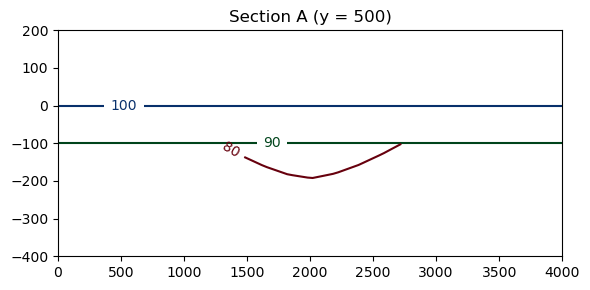

In [61]:
y_transects = 500

Ground_levels = [-999, 100]
Quaternary_levels = [-999, 90]
Warnbro_levels = [-999, 80]

fig, ax = plt.subplots(1,1,figsize=(6,3))

delx, delz = 100, 200
x, z = np.linspace(x0,x1,delx), np.linspace(z0,z1,delz)
xx, zz = np.meshgrid(x,z)
yy = np.zeros_like(xx)
yy[:] = y_transects
ax.set_title('Section A (y = %i)' %y_transects)

vals1 = geomodel.evaluate_feature_value('Ground',np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T)
cf1 = ax.contour(vals1.reshape((delz, delx)), cmap = 'Blues', levels = Ground_levels, extent=(x0, x1, z0, z1))
ax.clabel(cf1, inline=True, fontsize=10)

vals2 = geomodel.evaluate_feature_value('Quaternary',np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T)
cf2 = ax.contour(vals2.reshape((delz, delx)), cmap = 'Greens', levels = Quaternary_levels, extent=(x0, x1, z0, z1))
ax.clabel(cf2, inline=True, fontsize=10)

vals3 = geomodel.evaluate_feature_value('Warnbro',np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T)
cf3 = ax.contour(vals3.reshape((delz, delx)), cmap = 'Reds', levels = Warnbro_levels, extent=(x0, x1, z0, z1))
ax.clabel(cf3, inline=True, fontsize=10)

plt.tight_layout() 
plt.show()